# Kaggle Competition - Histopathologic Cancer Detection
## Alex Jocius
### https://github.com/aajocius/CSPB-3202.git

# Project Description

This project attempts to create a Convolutional Neural Network (CNN) to correctly identify metastatic cancer in small image patches.  The original scope of this project was outlined in a Kaggle competition seen here: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

The orignal dataset consists of large number of small pathology images, split between test and train sets.  The training dataset has a corresponding csv file that identifies the correct classificaiton (0 = benign, 1 = malignant).  The orignal training dataset consists of about 200K images, in a .tif format.  Each image contains a 32 x 32 pixel patch that is used to identify the presence of cancer.  The test dataset consists of around 57.5K images that is used to determine model accuracy and score participants.

In [65]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import itertools
import shutil
import random
import os
import zipfile

# Exploratory Data Analysis

I will first pull the training labels to determine the counts of each diagnosis category. In addition, I will take a look at how many entries exist within the training dataset.  I can see that there are 220,025 entries, which is aligned with the number of entries shown in Kaggle. Based on some discussions on the Kaggle discussion boards, I decided to remove two images from my dataframe that seemed to be giving some people some issues.

In [3]:
train_labels = pd.read_csv("train_labels.csv", dtype=str)
train_labels = train_labels.astype({'label': int})
train_labels[train_labels['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
train_labels[train_labels['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
print(train_labels.shape)

(220025, 2)


I will print out the first 5 rows of the training label dataset to ensure the data was imported properly before continuing with and EDA.

In [4]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Next, I will examine the counts for each diagnosis category.  Ideally, there would be a fairly even split between benign and malignant cases. I can see that around 60% of the data consists of benign cases and 40% consists of malignant cases.  This should be a good split to train my network with.

In [5]:
cat_counts = train_labels['label'].value_counts()
print('0: {:.2%}'.format(cat_counts[0] / train_labels.shape[0]))
print('1: {:.2%}'.format(cat_counts[1] / train_labels.shape[0]))

0: 59.50%
1: 40.50%


I will plot a bar chart of this result to better visualize the distribution.

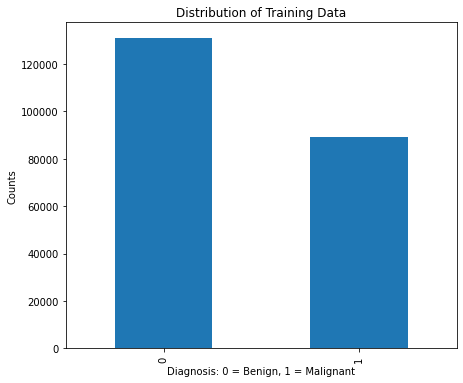

In [6]:
train_labels['label'].value_counts().plot(kind='bar', figsize=(7, 6))
plt.xlabel("Diagnosis: 0 = Benign, 1 = Malignant")
plt.ylabel("Counts")
plt.title("Distribution of Training Data");

I now need to invesigate and visualize the images within the training set to determine how each image is formatted.  I will take the first four image id's in the train_label dataset and display them.  I will also print out the shape of the initial image to gauge the pixel structure of each image.

In [7]:
id = train_labels['id'][0]
image = mpimg.imread('train/{}.tif'.format(id))
print(image.shape)
print(type(image))

(96, 96, 3)
<class 'numpy.ndarray'>


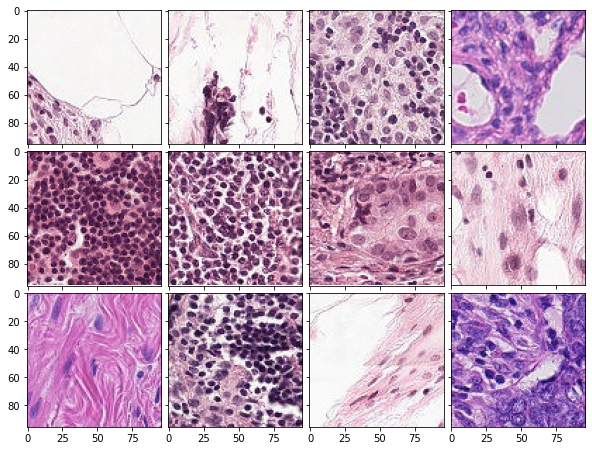

In [8]:
images = []
for i in range(12):
  images.append(mpimg.imread('train/{}.tif'.format(train_labels['id'][i])))

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 4),
                 axes_pad=0.1)
for ax, im in zip(grid, images):
  ax.imshow(im)

plt.show()

# Data Preperation

I will reduce my data size to 80,000 samples for each category, malignant and benign.  Having an equal split will help to prevent overfitting for a particular class. This seemed to be a common split used on this dataset after reviewing some material on the kaggle website

In [9]:
SAMPLES_PER_CAT = 80000

In [10]:
train_benign = train_labels[train_labels['label'] == 0].sample(n=SAMPLES_PER_CAT, random_state = 1)
train_malignant = train_labels[train_labels['label'] == 1].sample(n=SAMPLES_PER_CAT, random_state = 1)

train_new = pd.concat([train_benign, train_malignant], axis=0).reset_index(drop=True)

train_new = shuffle(train_new)

train_new['label'].value_counts()

train_new.head()

,id,label
73174,04d24666b8a82c7baf63eaaaddf42ac7be8c2568,0
37849,5135f25df70c9fe9d3e6eba45177c57039e7bd7a,0
56166,c5ee5ac3b4edfebdb31618e367fe3a9e45a308f1,0
139703,c61ec8bbb4d381554a883fbbd921aa17f2d1c20f,1
54370,2f94644324894bdc81898ad04f15240d13e2e948,0


I have already created new directories that will be used in the subsqeuent sections to split and arrange the data into validation and training subsets.

I will sklearns train_test_split to seperate the images into training and validation sets using an 80/20 split. Stratify will ensure that my split data will have the same percentages of benign and malignant cases after the split.

In [11]:
train_df, val_df = train_test_split(train_new, test_size=.2, random_state=1, stratify=train_new.label)
print(train_df.shape)
print(val_df.shape)

(128000, 2)
(32000, 2)


In [12]:
train_new.set_index('id', inplace=True)

train_lst = list(train_df['id'])
val_lst = list(val_df['id'])

I will seperate out my validation images into new folders depending on the class of the image.  This code was borrowed from [2].

for image in val_lst:
  fname = image + '.tif'
  target = train_new.loc[image, 'label']

  if target == 0:
    label = 'benign'
  else:
    label = 'malignant'
  
  src = os.path.join('train', fname)

  dst = os.path.join('val_new', label, fname)

  shutil.copyfile(src, dst)

Keras' ImageDataGenerator allows batches of tensor image data to be collected and also allows real-time data agumentation to be implemented. This can extremly useful for datasets that are small, extending the dataset by augmenting each image with a variety of techniques.  I wanted to experiment with this method here, and have shown how to augment a single image. I did not implement this technique to the wider dataset, as the dataset is already quite large and would have slowed down computation. I found a great article that helped walked me through this process [5].

In [14]:
generator = ImageDataGenerator(rotation_range=359, zoom_range=.1, horizontal_flip=True, vertical_flip=True, brightness_range=(.2, .8), channel_shift_range=10.)

In [15]:
chosen_image = train_labels.iloc[0]['id'] + '.tif'
image_path = 'train/' + chosen_image
print(image_path)

train/f38a6374c348f90b587e046aac6079959adf3835.tif


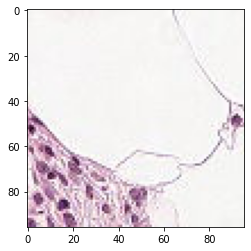

In [16]:
image = np.expand_dims(plt.imread(image_path), 0)
plt.imshow(image[0])

In [17]:
aug_iter = generator.flow(image)

In [18]:
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(4)]

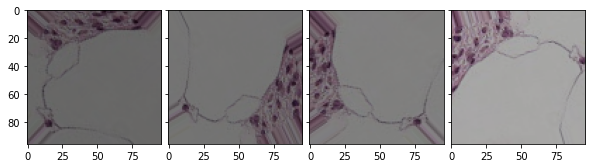

In [19]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 4),
                 axes_pad=0.1)
for ax, im in zip(grid, aug_images):
  ax.imshow(im)

plt.show()

We can see that the orginal image has been rotated, scaled, flipped and had it's brightness changed.  This method would prove very useful to expand a small dataset.

I will now transfer the training images into the new folders that were previously made, similiar to the method used for the validation data set.

for image in train_lst:
  fname = image + '.tif'
  target = train_new.loc[image, 'label']

  if target == 0:
    label = 'benign'
  else:
    label = 'malignant'

  src = os.path.join('train', fname)

  dst = os.path.join('train_new', label, fname)

  shutil.copyfile(src, dst)

To make sure that the images have been correctly moved to the right location I will check the length of each folder, shown below.

In [20]:
  train_b_len = len(os.listdir('train_new/benign'))
  train_m_len = len(os.listdir('train_new/malignant'))
  len_trainset = train_b_len + train_m_len
  print(train_b_len)
  print(train_m_len)

64000
64000


In [21]:
  val_b_len = len(os.listdir('val_new/benign'))
  val_m_len = len(os.listdir('val_new/malignant'))
  len_valset = val_b_len + val_m_len
  print(val_b_len)
  print(val_m_len)

16000
16000


# CNN Model

I next set my training, validation, and test paths and create batch sizes for the training and validation sets. Batch size is essentially a hyperparameter that can tuned to obtain good results.  However, using a small batch size will certianly affect computational performance.  I chose to use a batch sizes of 32 and 16, as to keep them small enough to obtain good results but also to try to speed up computation time, compared to a smaller batch size. I again used ImageDataGenerator to rescale my images and to create these batches.

In [22]:
train_path = 'train_new'
val_path = 'val_new'
test_path = 'test'

In [23]:
train_batch_size = 32
val_batch_size = 16

train_steps = np.ceil(len_trainset / train_batch_size)
val_steps = np.ceil(len_valset / val_batch_size)

In [37]:
train_batches = ImageDataGenerator(rescale=1.0/255).flow_from_directory(train_path, target_size=(96, 96), classes=['benign', 'malignant'], batch_size=train_batch_size)
val_batches = ImageDataGenerator(rescale=1.0/255).flow_from_directory(val_path, target_size=(96, 96), classes=['benign', 'malignant'], batch_size=val_batch_size)
test_batches = ImageDataGenerator(rescale=1.0/255).flow_from_directory(val_path, target_size=(96, 96), classes=['benign', 'malignant'], batch_size = 1, shuffle=False)

Found 128000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.


I intially played around with a simple CNN network to get used to working in Keras. To no suprise, these simple models did not perform well. I decided to do some research on CNN models used for binary classification in order to get some idea how these models are stuctured. I came across the VG16 model and decided that it would be a great starting point.  

We can see that this model has 13 convolutional layers, 5 max pooling layers, and 3 fully connected layers.  The same kernel size is used across all the convolutional layers and a constant padding size is used to keep the image size intact after the convolutional layers.  In a similar manner, the max pooling size and stride is kept the same across the network and essentially halves the resolution of the image each time.  

I thought the simplicity of this model and its focus on small sections would lead to good results for this project.  I thought using small kernel sizes acrosses the convolutional layers would allow for specific features to be detected. The consistent max pooling layers should help to pick up the most important features.  The convolution layers all use the ReLu Activation function, which seems to be standard practice for CNNs. I used a Softmax activation on my output as I am using one-hot incoding.  However, a sigmoid activation function could have been used as well.[4].

In [27]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape = (96, 96, 3), padding="same", activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2))) 

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096, activation = "relu"))
model.add(Dense(units=4096, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                    

I will compile my model with a couple of optimizers, including the Adam optimizer that has shown to be effective in deep learning models as an alternative to SGD.  I will also use early stopping in my model, however, I have set the patience value high as I have time to run all epochs.  

In [28]:
model.compile(Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, mode='max')

In [30]:
hist = model.fit(train_batches, steps_per_epoch=train_steps, validation_data=val_batches, validation_steps=val_steps, epochs=30, verbose=2, callbacks=[checkpoint, early])

Epoch 1/30
4000/4000 - 394s - loss: 0.4342 - accuracy: 0.8011 - val_loss: 0.3601 - val_accuracy: 0.8412 - 394s/epoch - 99ms/step
Epoch 2/30
4000/4000 - 381s - loss: 0.2992 - accuracy: 0.8746 - val_loss: 0.2556 - val_accuracy: 0.8912 - 381s/epoch - 95ms/step
Epoch 3/30
4000/4000 - 373s - loss: 0.2287 - accuracy: 0.9084 - val_loss: 0.2240 - val_accuracy: 0.9114 - 373s/epoch - 93ms/step
Epoch 4/30
4000/4000 - 374s - loss: 0.1880 - accuracy: 0.9279 - val_loss: 0.1733 - val_accuracy: 0.9359 - 374s/epoch - 93ms/step
Epoch 5/30
4000/4000 - 372s - loss: 0.1634 - accuracy: 0.9385 - val_loss: 0.1835 - val_accuracy: 0.9310 - 372s/epoch - 93ms/step
Epoch 6/30
4000/4000 - 371s - loss: 0.1397 - accuracy: 0.9485 - val_loss: 0.1541 - val_accuracy: 0.9438 - 371s/epoch - 93ms/step
Epoch 7/30
4000/4000 - 369s - loss: 0.1197 - accuracy: 0.9566 - val_loss: 0.1767 - val_accuracy: 0.9346 - 369s/epoch - 92ms/step
Epoch 8/30
4000/4000 - 369s - loss: 0.0997 - accuracy: 0.9649 - val_loss: 0.1560 - val_accuracy: 

We can inspect the performance of the model across the training and validation sets by plotting the metrics across each epoch. We can see that the validation accuracy really didn't get better acter around the 5th epoch, therefore setting my early stopping to around 5 epochs could have saved me some time.

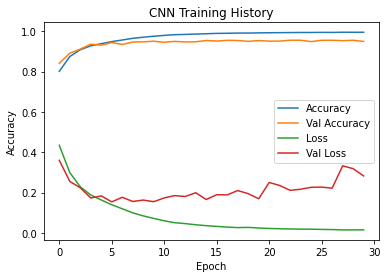

In [31]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("CNN Training History")
plt.ylabel('Accuracy')
plt.xlabel("Epoch")
plt.legend(['Accuracy', 'Val Accuracy', 'Loss', 'Val Loss'])
plt.show()

I will now make predictions on my validation set in order to provide certain metrics for accessing the validaity of the model.

In [67]:
model.load_weights('model.h5')

In [68]:
predictions = model.predict_generator(test_batches, steps=len_valset, verbose=1)

    2/32000 [..............................] - ETA: 44:07

C:\Users\jociu\AppData\Local\Temp\ipykernel_14424\3946155421.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=len_valset, verbose=1)


32000/32000 [==============================] - 187s 6ms/step


In [69]:
classes = ['Benign', 'Malignant']

I will transfer these predictions to a Pandas Dataframe to use in future plots.

In [70]:
df_predictions = pd.DataFrame(predictions, columns=classes)
df_predictions.head()

,Benign,Malignant
0,1.000000,7.948096e-09
1,1.000000,4.687548e-13
2,1.000000,4.397318e-16
3,1.000000,2.829464e-10
4,0.999666,3.337783e-04


In [71]:
valid_label_true = test_batches.classes

valid_label_pred = df_predictions['Malignant']

# Model Analysis

I will now plot the confusion matrix of the predictions made on the validation set.  The confusion matrix will help us visulalize the true positives, true negatives, false positives, and false negatives.  These values are critical when developing and analyzing machine learning models. We do not want to misclassify someone as having cancer when in fact they don't, and we certainly do not want to misclassiy a person as not having cancer when in fact they do.  We can visualize these values below:

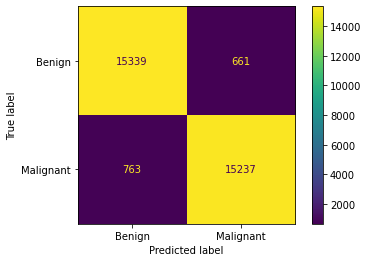

In [72]:
matrix_labels = test_batches.classes

cm = confusion_matrix(matrix_labels, predictions.argmax(axis=1))

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

We can see from the confusion matrix that although the model did well, ideally I would want to get the false positive and negative rates down.  

I will also print out a classifcation report from sklearns metrics class.  This will give us values of precision, recall, and f1-score across the different classes. We can see that the model did about equally well on classifying benign and malignant cases.

In [53]:
valid_label_binary = predictions.argmax(axis=1)

class_report = classification_report(valid_label_true, valid_label_binary, target_names=classes)

print(class_report)

              precision    recall  f1-score   support

      Benign       0.95      0.96      0.96     16000
   Malignant       0.96      0.95      0.96     16000

    accuracy                           0.96     32000
   macro avg       0.96      0.96      0.96     32000
weighted avg       0.96      0.96      0.96     32000



# Submission

I will now package my predictions for the test images.

In [55]:
test_df = pd.read_csv('sample_submission.csv')

In [56]:
def extHelper(fname):
    return fname + ".tif"

In [57]:
test_df['id'] = test_df['id'].apply(extHelper)

In [59]:
test_gen = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(dataframe=test_df, directory="test/", x_col='id',
                                                                   batch_size=32, shuffle=False, class_mode=None,
                                                                   target_size=(96, 96))

Found 57458 validated image filenames.


In [60]:
model_to_use = keras.models.load_model('model.h5')

In [61]:
final_predictions = model_to_use.predict(test_gen)

1796/1796 [==============================] - 92s 51ms/step


In [62]:
submission = pd.read_csv("sample_submission.csv")
submission.label = final_predictions[:,1]
submission.to_csv('submission.csv', header=True, index=False)

This gave me a score of 93.05 on the public set and a score of 92.04 on the private set.  For some reason, it wasn't showin me on the leaderboard, therefore I am posting a picture of my submission score below.

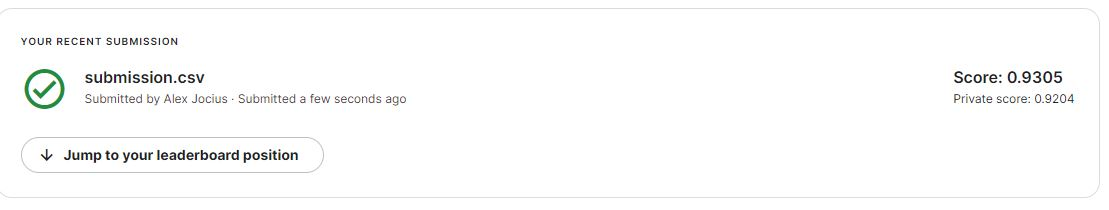

References:


1.   https://matplotlib.org/stable/tutorials/introductory/images.html
2.   https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html
3.   https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing
4.   https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
5.   https://deeplizard.com/learn/video/14syUbL16k4




